In [19]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Data
df = pd.read_csv('aqi_cleaned.csv')

# Features: all hours except 23:00
X = df.drop(columns=['Days', '23:00:00'])
# Target: AQI at 23:00
y = df['23:00:00']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 19.721014492753625
R² Score: 0.8796179400122388


In [20]:
import pandas as pd
from prophet import Prophet

# Load data
df = pd.read_csv('aqi_cleaned.csv')

# Melt dataframe to long format
df_long = df.melt(id_vars='Days', var_name='Time', value_name='AQI')

# Validate and clean Days and Time columns
# Ensure Days is a valid date
df_long['Days'] = pd.to_datetime(df_long['Days'], errors='coerce')

# Ensure Time is a valid time
df_long['Time'] = pd.to_datetime(df_long['Time'], format='%H:%M:%S', errors='coerce').dt.time

# Drop rows with invalid Days or Time
df_long = df_long.dropna(subset=['Days', 'Time'])

# Combine Days and Time into a single datetime column
df_long['Date'] = pd.to_datetime(df_long['Days'].astype(str) + ' ' + df_long['Time'].astype(str), errors='coerce')

# Drop rows with invalid Date and sort
df_long = df_long[['Date', 'AQI']].dropna().sort_values('Date')

# Rename columns for Prophet
df_long = df_long.rename(columns={'Date': 'ds', 'AQI': 'y'})

# Prophet model
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(df_long)

# Create future dataframe for the next 7 days (24 hours each)
future = model.make_future_dataframe(periods=7*24, freq='H')

# Forecast
forecast = model.predict(future)

# Show the forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(24 * 7)  # Last 7 days predictions

C:\Users\deysh\AppData\Local\Temp\ipykernel_14224\866598885.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['Days'].astype(str) + ' ' + df_long['Time'].astype(str), errors='coerce')
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\deysh\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds,yhat,yhat_lower,yhat_upper
8208,1970-01-02 00:00:00.000000365,203.434298,102.159383,312.385609
8209,1970-01-02 01:00:00.000000365,198.221041,96.008767,309.760783
8210,1970-01-02 02:00:00.000000365,193.625473,86.432850,303.436804
8211,1970-01-02 03:00:00.000000365,190.111583,83.701150,292.881548
8212,1970-01-02 04:00:00.000000365,185.753913,83.744709,286.595549
...,...,...,...,...
8371,1970-01-08 19:00:00.000000365,128.794555,18.613025,234.373092
8372,1970-01-08 20:00:00.000000365,142.175255,32.376201,249.152690
8373,1970-01-08 21:00:00.000000365,159.684460,48.254715,253.240288
8374,1970-01-08 22:00:00.000000365,173.908594,67.543464,276.656746


In [21]:
import pandas as pd
from prophet import Prophet

# Step 1: Load Data
df = pd.read_csv('aqi_cleaned.csv')

# Step 2: Reshape Data to Long Format
df_long = df.melt(id_vars='Days', var_name='Time', value_name='AQI')

# Step 3: Convert 'Days' to 2025-based Dates
# Assuming Day 1 = 2025-01-01
df_long['Days'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(df_long['Days'] - 1, unit='D')

# Step 4: Convert 'Time' to proper time format
df_long['Time'] = pd.to_datetime(df_long['Time'], format='%H:%M:%S', errors='coerce').dt.time

# Drop invalid rows
df_long.dropna(subset=['Days', 'Time'], inplace=True)

# Step 5: Combine Days and Time into a single datetime column
df_long['Date'] = pd.to_datetime(df_long['Days'].astype(str) + ' ' + df_long['Time'].astype(str), errors='coerce')

# Final Cleanup: Keep valid Date and AQI
df_long = df_long[['Date', 'AQI']].dropna().sort_values('Date')

# Step 6: Rename for Prophet
df_long.rename(columns={'Date': 'ds', 'AQI': 'y'}, inplace=True)

# Step 7: Build and Train Prophet Model
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(df_long)

# Step 8: Create Future Dates (7 days * 24 hours)
future = model.make_future_dataframe(periods=7 * 24, freq='H')

# Step 9: Forecast
forecast = model.predict(future)

# Step 10: Clean Output Table
forecast_result = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7 * 24)

# Format Date for readability
forecast_result['ds'] = forecast_result['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')

forecast_result.rename(columns={
    'ds': 'Date & Time',
    'yhat': 'Predicted AQI',
    'yhat_lower': 'Lower Confidence',
    'yhat_upper': 'Upper Confidence'
}, inplace=True)

# Display
print("\n📢 Upcoming AQI Forecast for the Next 7 Days (Starting 2025):\n")
print(forecast_result.to_string(index=False))


10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\deysh\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(



📢 Upcoming AQI Forecast for the Next 7 Days (Starting 2025):

        Date & Time  Predicted AQI  Lower Confidence  Upper Confidence
2026-01-01 00:00:00     315.232221        235.833789        393.801745
2026-01-01 01:00:00     311.309878        225.183023        394.244120
2026-01-01 02:00:00     307.385404        231.854564        392.336650
2026-01-01 03:00:00     304.013143        224.486777        384.233442
2026-01-01 04:00:00     299.675120        218.681086        384.265996
2026-01-01 05:00:00     293.927511        214.302571        378.994124
2026-01-01 06:00:00     289.088393        210.198293        372.858674
2026-01-01 07:00:00     288.474232        208.660648        365.315575
2026-01-01 08:00:00     292.909802        213.897779        375.138842
2026-01-01 09:00:00     299.184591        223.507350        378.587123
2026-01-01 10:00:00     302.291860        222.588464        385.306954
2026-01-01 11:00:00     299.499204        220.668537        382.397835
2026-01-01 12:

In [22]:
import pandas as pd

# Load Data
df = pd.read_csv('aqi_cleaned.csv')

# Convert 'Days' to actual calendar dates assuming Day 1 = 2025-01-01
df['Date'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(df['Days'] - 1, unit='D')

# Remove 'Days' and set 'Date' as index for easy searching
aqi_data = df.set_index('Date')

# User Input
user_input = input("📅 Enter a date (YYYY-MM-DD): ")

try:
    user_date = pd.to_datetime(user_input).normalize()  # Ensure time part is 00:00:00

    if user_date in aqi_data.index:
        selected_row = aqi_data.loc[user_date]

        # Display the AQI for each hour
        print(f"\n✅ Air Quality Index (AQI) for {user_date.date()}:\n")
        for hour in range(24):
            hour_label = f"{hour:02d}:00:00"
            if hour_label in selected_row:
                print(f"🕰 {hour_label} => AQI: {selected_row[hour_label]}")
    else:
        print(f"\n⚠️ Sorry, no AQI data found for {user_input}. Please try another date!")

except Exception as e:
    print(f"❌ Invalid date format! Please enter the date in YYYY-MM-DD format.\nError: {e}")



✅ Air Quality Index (AQI) for 2025-01-01:

🕰 00:00:00 => AQI: 265.0
🕰 01:00:00 => AQI: 211.0
🕰 02:00:00 => AQI: 204.0
🕰 03:00:00 => AQI: 191.0
🕰 04:00:00 => AQI: 186.0
🕰 05:00:00 => AQI: 184.0
🕰 06:00:00 => AQI: 161.0
🕰 07:00:00 => AQI: 143.0
🕰 08:00:00 => AQI: 151.0
🕰 09:00:00 => AQI: 162.0
🕰 10:00:00 => AQI: 183.0
🕰 11:00:00 => AQI: 202.0
🕰 12:00:00 => AQI: 196.0
🕰 13:00:00 => AQI: 166.0
🕰 14:00:00 => AQI: 150.0
🕰 15:00:00 => AQI: 124.0
🕰 16:00:00 => AQI: 128.0
🕰 17:00:00 => AQI: 122.0
🕰 18:00:00 => AQI: 111.0
🕰 19:00:00 => AQI: 111.0
🕰 20:00:00 => AQI: 180.0
🕰 21:00:00 => AQI: 240.0
🕰 22:00:00 => AQI: 260.0
🕰 23:00:00 => AQI: 280.0


DatePicker(value=datetime.date(2025, 1, 1), description='📅 Pick a date:', step=1)

,Time,AQI
0,00:00:00,273.0
1,01:00:00,339.0
2,02:00:00,297.0
3,03:00:00,250.0
4,04:00:00,266.0
5,05:00:00,243.0
6,06:00:00,231.0
7,07:00:00,243.0
8,08:00:00,268.0
9,09:00:00,273.0


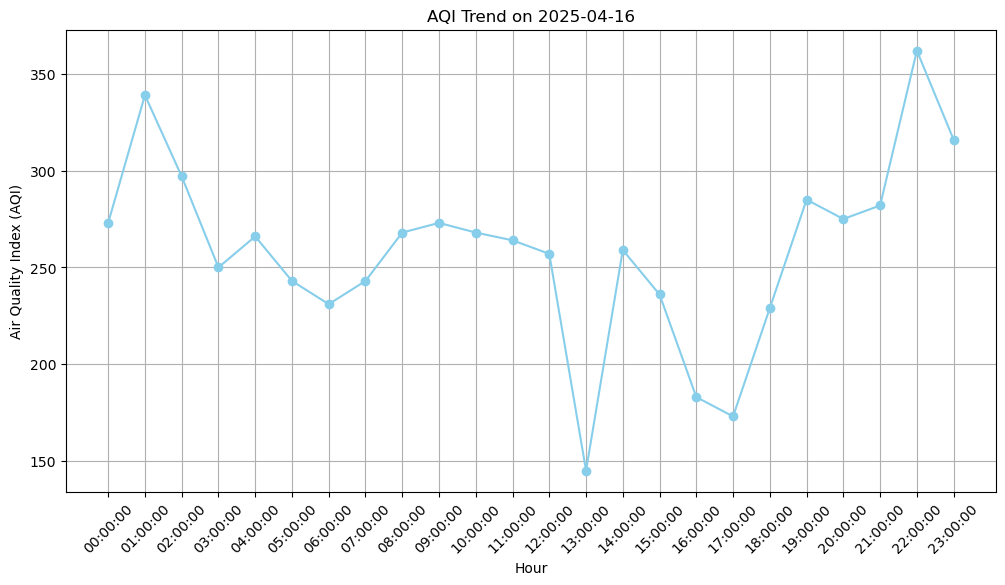

In [28]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Step 2: Load the Data
df = pd.read_csv('aqi_cleaned.csv')

# Step 3: Convert 'Days' to 2025 Date Format
df['Date'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(df['Days'] - 1, unit='D')

# Step 4: Create Date Picker Widget
date_picker = widgets.DatePicker(
    description='📅 Pick a date:',
    disabled=False,
    value=pd.to_datetime('2025-01-01').date()
)

display(date_picker)

# Step 5: Create Function to Update Display
def show_aqi_data(change):
    user_date = pd.to_datetime(change['new'])
    
    filtered = df[df['Date'] == user_date]

    if not filtered.empty:
        print(f"\n✅ AQI Data for {user_date.date()}:\n")
        hourly_aqi = filtered.drop(columns=['Days', 'Date']).T.reset_index()
        hourly_aqi.columns = ['Time', 'AQI']
        display(hourly_aqi)

        # Step 6: Plot AQI Trend
        plt.figure(figsize=(12,6))
        plt.plot(hourly_aqi['Time'], hourly_aqi['AQI'], marker='o', color='skyblue')
        plt.title(f"AQI Trend on {user_date.date()}")
        plt.xlabel('Hour')
        plt.ylabel('Air Quality Index (AQI)')
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.show()
    else:
        print("\n⚠️ No data available for the selected date. Try another date!")

# Step 7: Attach Event Listener
date_picker.observe(show_aqi_data, names='value')


In [5]:
# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

# Step 2: Load the Data
df = pd.read_csv('aqi_cleaned.csv')

# Step 3: Convert 'Days' to 2025 Date Format
df['Date'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(df['Days'] - 1, unit='D')

# Step 4: Define AQI Category Function
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 200:
        return 'Poor'
    elif aqi <= 300:
        return 'Very Poor'
    else:
        return 'Severe'

# Step 5: Create Widgets
date_picker = widgets.DatePicker(
    description='📅 Pick a date:',
    disabled=False,
    value=pd.to_datetime('2025-01-01').date()
)

output_area = widgets.Output()

# Display the widgets
display(date_picker, output_area)

# Step 6: Update Function
def show_aqi_data(change):
    user_date = pd.to_datetime(change['new'])
    
    with output_area:
        output_area.clear_output()
        filtered = df[df['Date'] == user_date]

        if not filtered.empty:
            print(f"\n✅ AQI Data for {user_date.date()}:\n")
            hourly_aqi = filtered.drop(columns=['Days', 'Date']).T.reset_index()
            hourly_aqi.columns = ['Time', 'AQI']

            # Add Category Column
            hourly_aqi['Category'] = hourly_aqi['AQI'].apply(classify_aqi)
            display(hourly_aqi)

            # Plot
            plt.figure(figsize=(12,6))
            plt.plot(hourly_aqi['Time'], hourly_aqi['AQI'], marker='o', color='skyblue')
            plt.title(f"AQI Trend on {user_date.date()}")
            plt.xlabel('Hour')
            plt.ylabel('Air Quality Index (AQI)')
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()

            # Summary
            max_aqi = hourly_aqi['AQI'].max()
            overall_category = classify_aqi(max_aqi)
            print(f"🧾 **Day Summary:** Max AQI = {max_aqi} → Category: {overall_category}")
        else:
            print("\n⚠️ No data available for the selected date. Try another date!")

# Step 7: Attach Listener
date_picker.observe(show_aqi_data, names='value')

# Trigger display for initial date
show_aqi_data({'new': date_picker.value})


DatePicker(value=datetime.date(2025, 1, 1), description='📅 Pick a date:', step=1)

Output()

DatePicker(value=datetime.date(2025, 1, 1), description='📅 Pick a date:', step=1)

Output()


📊 Cross-Validation Scores: [1.         0.98550725 1.         1.         1.        ]
Mean Accuracy: 0.9971014492753623


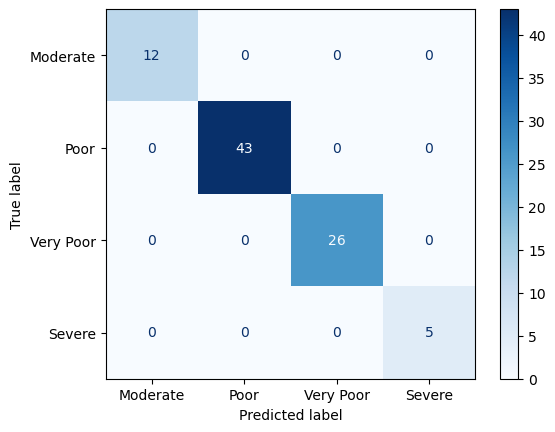


🔍 Classification Report:
               precision    recall  f1-score   support

    Moderate       1.00      1.00      1.00        12
        Poor       1.00      1.00      1.00        43
   Very Poor       1.00      1.00      1.00        26
      Severe       1.00      1.00      1.00         5

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86


🚀 Ensemble Model Accuracy: 1.0


In [ ]:
# 📌 AQI Dashboard + Model Pipeline — Clean Version (SHAP Removed)

# Step 1: Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import joblib

# Step 2: Load Dataset
df = pd.read_csv('aqi_cleaned.csv')
df['Date'] = pd.to_datetime('2025-01-01') + pd.to_timedelta(df['Days'] - 1, unit='D')

# Step 3: Categorize AQI Function
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 200:
        return 'Poor'
    elif aqi <= 300:
        return 'Very Poor'
    else:
        return 'Severe'

# Step 4: AQI Interactive Dashboard
date_picker = widgets.DatePicker(description='📅 Pick a date:', value=pd.to_datetime('2025-01-01').date())
output_area = widgets.Output()
display(date_picker, output_area)

def show_aqi_data(change):
    user_date = pd.to_datetime(change['new'])
    with output_area:
        output_area.clear_output()
        filtered = df[df['Date'] == user_date]

        if not filtered.empty:
            print(f"\n✅ AQI Data for {user_date.date()}:\n")
            hourly_aqi = filtered.drop(columns=['Days', 'Date']).T.reset_index()
            hourly_aqi.columns = ['Time', 'AQI']
            hourly_aqi['Category'] = hourly_aqi['AQI'].apply(classify_aqi)
            display(hourly_aqi)

            plt.figure(figsize=(12,6))
            plt.plot(hourly_aqi['Time'], hourly_aqi['AQI'], marker='o', color='skyblue')
            plt.title(f"AQI Trend on {user_date.date()}")
            plt.xlabel('Hour')
            plt.ylabel('Air Quality Index (AQI)')
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.show()

            max_aqi = hourly_aqi['AQI'].max()
            print(f"🧾 **Day Summary:** Max AQI = {max_aqi} → Category: {classify_aqi(max_aqi)}")
        else:
            print("\n⚠️ No data available for the selected date. Try another date!")

date_picker.observe(show_aqi_data, names='value')
show_aqi_data({'new': date_picker.value})

# Step 5: Modeling Section
df['Avg_AQI'] = df.iloc[:, 1:25].mean(axis=1)  # assuming hourly AQI columns are 1-24
df['Label'] = df['Avg_AQI'].apply(lambda aqi: 0 if aqi <= 50 else 1 if aqi <= 100 else 2 if aqi <= 200 else 3 if aqi <= 300 else 4)

X = df[['Avg_AQI']]
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train RandomForest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Save Model
joblib.dump(rf_model, 'aqi_rf_model.pkl')

# Generalizability Check
scores = cross_val_score(RandomForestClassifier(random_state=42), X, y, cv=5, scoring='accuracy')
print("\n📊 Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

# Predict and Generate Confusion Matrix
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

# Dynamic Label Selection Fix
unique_labels = sorted(list(set(y_test) | set(y_pred)))
class_names = ['Good', 'Moderate', 'Poor', 'Very Poor', 'Severe']
display_labels = [class_names[i] for i in unique_labels]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.show()

# Classification Report
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred, target_names=display_labels))

# Innovation: Ensemble Model Example
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

ensemble_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000))
], voting='soft')

ensemble_model.fit(X_train, y_train)
print("\n🚀 Ensemble Model Accuracy:", ensemble_model.score(X_test, y_test))
